# Principal Component Analysis

PCA is a technique used to reduce the dimensionality of the dataset. It can lead to inferences about underlying variables and their combined behaviour. Data can become more interpretable, preserving as much information as possible. Visualisation of results is appealing.

## Helicopter View into simple PCA Decomposition 

Let's make sure that we run the following command to install all needed packages:
`pip install -r requirements.txt`

Next, we're ready to import all relevant packages that were just installed:
* `numpy` for basic mathematical operations
* `pandas` for dataset manipulations 
* `matplotlib` for data visualisation with plots

In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

We're now ready to use them to generate a simple dataset. We'll implement a data-generating function the results of which we'll be using as inputs to our PCA. 

The **aim of our exercise is to show, that results of principal components analysis align with theoretical, expected outcomes** for the dataset generated using the above function.

Our samples will be drawn from a Gaussian distribution in two dimensions, as follows:

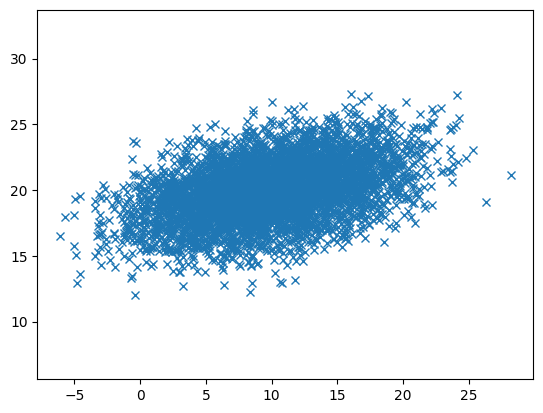

In [16]:
means = [10, 20]  # Means of marginal distributions
cov = [[25, 5], [5, 5]]  # diagonal covariance
x, y = np.random.multivariate_normal(means, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

PCA is based on eigenvalues and eigenvectors which can be computed using `numpy`:

In [17]:
values, vectors = np.linalg.eig(cov)
values[:5]

array([26.18033989,  3.81966011])

In [18]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(f"Total explained variance = {np.sum(explained_variances) * 100}%\nIndividual explained variances = {explained_variances}\n")

Total explained variance = 100.0%
Individual explained variances = [0.872677996249965, 0.12732200375003505]



We can see, that the variance is explained fully by the first two components. The first component explains over 87% of variance in the data. This is as expected, because the data was generated using two variables only. 

## What's Going on in Depth?

PCA is based on the process of ***eigendecomposition of the covariance matrix***. 

### Step 1 - Covariance

**Covariance** of two variables is a measure of their joint variance. It describes how **two parameters vary together**. 

We can infer a couple of interesting facts about the covariance matrix from that definition:
* Diagonal elements of the covariance matrix should describe the variance of individual variables. This is because they contain information about the variability of the pair of values $(e1, e1)$ which is essentially the same as the variability of $e1$ for some variable $e1$.
* Another observation is that the matrix should be symmetrical with respect to the transposition. That means, that elements $(e1, e2)$ vary in the same exact way as elements $(e2, e1)$. Note, that python libraries will raise a warning if the covariance matrix does not have that property.

### Step 2 - Eigendecomposition

The goal of this step is to find features (variables) which help explain the most of the original variance. That is to say, that if we exclude the remaining variables from the data set, we would observe the smallest possible decrease in overall variance given the number of features that we want to keep. 

Eigenvectors of a matrix which is symmetric (we know it is as per the above section) will be orthogonal - they will define a coordinate system. In that system, eigenvalues of the same matrix will contain information about feature importance. The largest eigenvalue will be connected to a direction which is explaining overall variance the most. Using this we can achieve the original goal of reducing the dimensionality in the original data set.

### Step 3 - Visualising the New Coordinate System

Let's apply our knowledge to the previous example data set:

In [19]:
# Let's define a simple function that will format a vector for later printing
def print_vector(v):
    return( "({}, {})" ).format(round(v[ 0 ], 2), round(v[ 1 ], 2))

In [20]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( vectors, values )):
    # Using the small helper function defined above
    print( f"Eigenvector {i}:\t{print_vector(v[ 0 ])} with value {round(v[ 1 ], 2)}" )

Eigenvector 0:	(0.97, -0.23) with value 26.18
Eigenvector 1:	(0.23, 0.97) with value 3.82


These eigenvectors are two-dimensional. We can easily plot them over the original data set as follows:

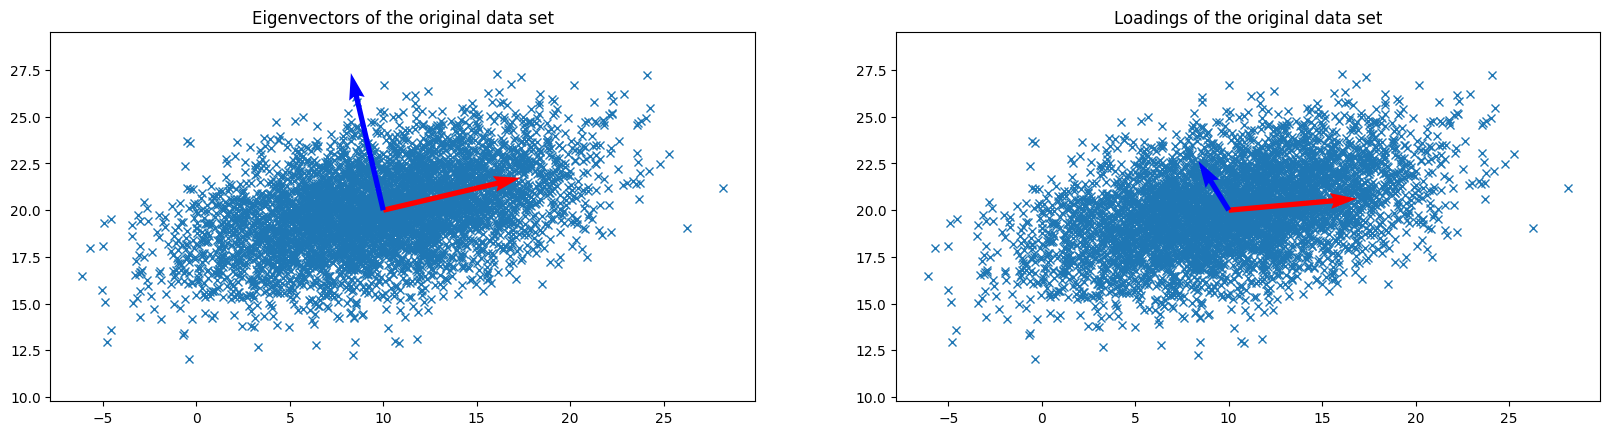

In [21]:
origin = [[means[0], means[0]], [means[1], means[1]]]

fig, ax = plt.subplots(nrows=1, ncols=2)

# Plotting actual eigenvectors on the left
ax[ 0 ].plot(x, y, 'x', zorder=1)
ax[ 0 ].axis('equal')
ax[ 0 ].set_title('Eigenvectors of the original data set')
ax[ 0 ].quiver(*origin, vectors[ 0 ], vectors[ 1 ], 
            color=['r','b'], scale=5, zorder=2)

# Plotting scaled eigenvectors - "loadings" on the righ. For details see references.
ax[ 1 ].plot(x, y, 'x', zorder=1)
ax[ 1 ].axis('equal')
# Loadings are eigenvectors which are scaled by the square root of the explained variance 
ax[ 1 ].set_title('Loadings of the original data set')
ax[ 1 ].quiver(*origin, 
               np.dot( vectors[ 0 ], np.sqrt( explained_variances[ 0 ] ) ), 
               np.dot( vectors[ 1 ], np.sqrt( explained_variances[ 1 ] ) ), 
            color=['r','b'], scale=5, zorder=2)

fig.set_figwidth(20)
plt.show()

It works! The first (red) eigenvector is in fact explaining most of the variance as computed above. The horizontal dispersion is dominant and receives more weight through the eigenvalue. The vertical dispersion is smaller in comparison and less important overall. Note, how the directions of eigenvectors appropriately reflect the tilt introduced by the correlation structure.

We will now download actual financial data observed in the market. That way we will observe the differences in PCA behavior between empirical data and data from the data generating process.

## Real-world Data

A good example of features varying together is a financial equity index. One of the most popular ones is the ***S&P500*** (*"Standard and Poor's 500"*). It measures cumulative performance of 500 selected largest US equity stocks that trade on the New York Stock Exchange. We will use PCA to explain the variability of this complex index by fewer stocks, that belong to this investment bucket. 

### Goal

Our goal is to show the individual stocks included in the S&P500 index that drive the overall variance the most.

### Dataset

We downloaded 5-year historical data containing information about stock prices of all S&P500 underliers as of February 2018 from Kaggle (link is in the References). We will use this dataset for our empirical study.

### Loading and Preparing the Dataset

Let's use `pandas` to load the dataset:

In [22]:
stocks = pd.read_csv('all_stocks_5yr.csv')
stocks.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [23]:
stocks.tail()

,date,open,high,low,close,volume,Name
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


We will be interested in the ***close*** column as it is a feature commonly used in the industry that offers accurate precision to reflect the stock price of a stock.

In [24]:
stocks = stocks[['date', 'close', 'Name']]
unique_names = pd.unique(stocks.loc[:,'Name'])

Let's now load the actual S&P500 prices for the same period:

In [25]:
import yfinance as yf
snp = yf.download("SPX", start="2013-02-08", end="2018-02-07")
snp.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-08,0.08306,0.08667,0.07944,0.08667,0.08667,489731
2013-02-11,0.09028,0.09028,0.08667,0.08667,0.08667,868053
2013-02-12,0.08306,0.08306,0.08306,0.08306,0.08306,473904
2013-02-13,0.07944,0.07944,0.07944,0.07944,0.07944,149173
2013-02-14,0.07583,0.07583,0.07583,0.07583,0.07583,57096


In [26]:
snp = snp[['Close']]
snp.tail()

,Close
Date,
2018-01-24,0.055
2018-01-25,0.055
2018-01-26,0.050
2018-01-29,0.050
2018-01-30,0.050


S&P data is not loaded for days between 2018-01-30 and 2018-02-07. We will trim individual stock prices scope to align with that limitation:

In [27]:
stocks = stocks[stocks['date'] <= '2018-01-30']
stocks.tail()

,date,close,Name
619029,2018-01-24,78.33,ZTS
619030,2018-01-25,79.25,ZTS
619031,2018-01-26,80.09,ZTS
619032,2018-01-29,79.18,ZTS
619033,2018-01-30,78.35,ZTS


We're ready for our decomposition now!

### Decomposition of the S&P500 Index - Covariance

The first step, as discussed before, is to obtain the covariance matrix. We cannot simply call `.cov()` on `stocks`, as all `close` values are in a single column spanning over all stocks that we have in the index. We need to re-pivot the data, so that every stock gets it's own `close` column with stock prices for all dates.

In [34]:
pivoted_stocks = pd.DataFrame(np.unique(stocks['date']), columns=['date'])
pivoted_stocks.set_index('date')
pivoted_stocks.head()

,date
0,2013-02-08
1,2013-02-11
2,2013-02-12
3,2013-02-13
4,2013-02-14


`pivoted_stocks` DataFrame defined above contains all possible unique dates. We will now try to extend this table with new columns for every stock name that we have. The `close` data will be joined to that table based on the date that we already put inside `pivoted_stocks`. 

If the code below is taking long (~60 seconds) to compute - **don't worry** - the dataset we're trying to process is fairly big :)

In [35]:
# Discussed in a comment inside the loop below
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for name in unique_names:                                                   # For all unique names that we have in the dataset
    prices_for_this_name = stocks[stocks['Name'] == name]                   # Find all prices for a given stock name 
    joined = pivoted_stocks.join(prices_for_this_name.set_index('date'),    # Join those individual stock prices with the list of unique dates
                                 on='date')
    pivoted_stocks[name] = joined['close'].values                           # Add a new column to the dataset with a name representing a stock
    
    #NOTE: Even though we get 'performance warnings', the above line is much much faster than the recommented pd.concat() below:
    #pivoted_stocks = pd.concat([pivoted_stocks, pd.Series(joined['close'].values, name=name)])

Finally, we can set `date` column as the index in the table and see how well it was populated:

In [38]:
pivoted_stocks.set_index('date', inplace=True)
pivoted_stocks.tail()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-24,54.79,174.22,120.99,105.51,104.62,61.72,160.60,197.78,95.34,42.84,...,73.48,36.86,88.53,61.83,32.36,72.57,85.24,125.02,53.74,78.33
2018-01-25,53.05,171.11,120.92,108.30,104.37,63.22,160.79,197.51,91.98,42.89,...,69.74,36.88,88.37,62.81,32.38,73.24,85.66,124.74,53.02,79.25
2018-01-26,53.07,171.51,123.64,123.21,105.48,63.42,162.55,201.30,93.84,43.59,...,71.94,36.67,89.00,62.84,32.83,74.41,86.20,126.23,54.02,80.09
2018-01-29,52.68,167.96,122.89,122.31,105.09,63.31,161.19,198.23,93.78,43.11,...,72.18,36.61,88.01,61.98,32.84,73.41,86.48,127.39,54.19,79.18
2018-01-30,52.59,166.97,119.27,115.88,102.46,62.44,159.70,196.90,91.55,42.48,...,72.13,36.62,86.78,61.40,32.68,73.07,84.59,125.94,53.93,78.35


Nice! Everything is in appropriate format. We're ready to compute the covariance matrix for this data!

In [41]:
stocks_cov = pivoted_stocks.cov()

### Decomposition of the S&P500 Index - Eigendecomposition

Now for the best part - obtaining the eigenvectors from the covariance matrix above:

In [42]:
eigenvalues, eigenvectors = np.linalg.eig(stocks_cov)

In [43]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( eigenvectors, eigenvalues )):
    # Using the small helper function defined above
    print( f"Eigenvector {i}:\t{print_vector(v[ 0 ])} with value {round(v[ 1 ], 2)}" )

Eigenvector 0:	(0.01, 0.03) with value 396555.09
Eigenvector 1:	(0.04, 0.03) with value 54837.35
Eigenvector 2:	(0.01, 0.12) with value 27631.41
Eigenvector 3:	(0.02, 0.01) with value 10831.05
Eigenvector 4:	(0.01, 0.06) with value 6526.9
Eigenvector 5:	(0.01, 0.01) with value 4946.43
Eigenvector 6:	(0.03, -0.0) with value -4198.29
Eigenvector 7:	(0.06, -0.01) with value 2488.8
Eigenvector 8:	(0.02, -0.0) with value 1856.27
Eigenvector 9:	(0.0, 0.02) with value 1495.81
Eigenvector 10:	(0.02, 0.0) with value 1049.43
Eigenvector 11:	(0.03, -0.01) with value -910.88
Eigenvector 12:	(0.01, 0.12) with value 819.61
Eigenvector 13:	(0.01, -0.0) with value 650.35
Eigenvector 14:	(0.01, 0.0) with value 624.46
Eigenvector 15:	(-0.0, 0.0) with value 497.88
Eigenvector 16:	(0.05, 0.02) with value -366.71
Eigenvector 17:	(0.01, -0.01) with value 430.41
Eigenvector 18:	(0.02, 0.23) with value 399.45
Eigenvector 19:	(0.01, 0.01) with value 377.7
Eigenvector 20:	(0.01, 0.01) with value 314.21
Eigenvec

The eigenvectors above are sorted in order of decreasing absolute valyue of the respective eigenvalue.

ValueError: Argument V has a size 5 which does not match 10, the number of arrow positions

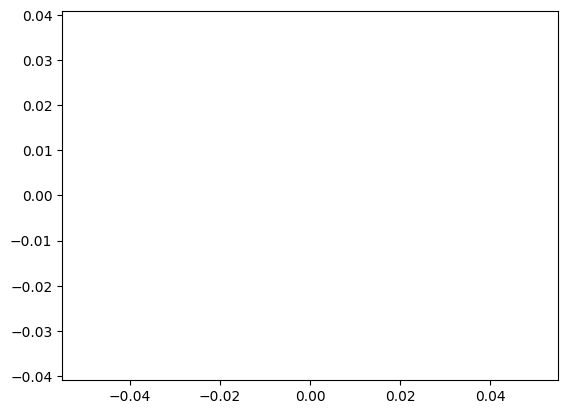

In [65]:
# Plotting top 5 (by abs(eigenvalue)) eigenvectors
origin = np.zeros(shape=(5, 2))

# Clear plot area
plt.cla()
plt.clf()

plt.axis('equal')

x = [ v[ 0 ] for v in eigenvectors[0:5] ]
y = [ v[ 1 ] for v in eigenvectors[0:5] ]
plt.quiver(np.zeros(shape=(5, 2)), x, y,
            color=[ 'b', 'b', 'b', 'b', 'b' ], scale=5, zorder=2)

#plt.set_figwidth(20)
plt.show()

We will apply the PCA methodology to equity prices, particularly in decomposing the pair relationships between multiple equities and their broader indices. Fundamentally, carving out the market component from the idiosyncratic one can demonstrate the varying impact of risk factors on the price of equities. The results are informative in nature, but can provide insight into expected moves of single name equities based on their index changes.

In [1]:
# Read sample equity data

## References
* https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
* https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another
* https://www.kaggle.com/datasets/camnugent/sandp500